Code Lab 2: PatchCamelyon (PCAM) Histopathological Cancer Detection 
===

## The Problem
PCam an image classification dataset based off of one of the Camelyon16 tasks where 96x96, 3-color channel image patches are extracted from whole-slide images (WSI).  These slides were extracted from histopathologic scans of lymph node sections in order to determine if the lymph nodes contain metastases (cancer cells).  From the Camelyon16 web page:
>  This task has a high clinical relevance but requires large amounts of reading time from pathologists. Therefore, a successful solution would hold great promise to reduce the workload of the pathologists while at the same time reduce the subjectivity in diagnosis. [1](https://camelyon16.grand-challenge.org/)

![pcam-cover](https://github.com/basveeling/pcam/raw/master/pcam.jpg)

In this lab, we will explore transfer learning and explainable AI (XAI) techniques on the PCam dataset.

## Imports

We will start off using a similar setup to Code Lab 1.

In [0]:
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import os
import pandas as pd
from IPython.display import display, HTML

In [3]:
import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print('Tensorflow version: ',tf.__version__)
print('Is GPU available: %s' % str(tf.test.is_gpu_available()))
print('Is Eager Execution enabled?: %s' % str(tf.executing_eagerly()))

Tensorflow version:  1.14.0
Is GPU available: True
Is Eager Execution enabled?: False


## Dataset

### About Pcam

PCam is contained in three data splits:
    1. Training: 262K samples
    2. Validation: 33K
    3. Testing: 33K

The patches are labeled 'positive' for containing a metastases if there was at least one pixel of segment in the central 32x32 region of the patch from the segmentation of the WSI that the patch was extracted from.  The dataset was constructed to be evenly balanced with 50/50 'present'/'not present'.

### Load the dataset

In [0]:
import boto3
import os

s3 = boto3.client('s3',
endpoint_url = 'https://s3.wasabisys.com',
aws_access_key_id = 'VM2WCNG36U812Y1NGCT3',
aws_secret_access_key='g3Dqovv3IYlIFDZyNWONXZSU5yhGZvWhKOJrBQRI')

def download_files(filenames, save_dir):
    for i, filename in enumerate(filenames):
         print('Downloading %d: %s' % (i, filename)) 
         download_file(filename, save_dir)

def download_file(filename, save_dir):
    full_filename = os.path.join(save_dir,filename)
    if os.path.exists(full_filename):
        print('\tAlready have: %s' % full_filename)
        return
    s3.download_file('curaedlhw',filename,full_filename)
    print('\tCOMPLETE: %s saved to %s' % (filename, save_dir))

In [5]:
dataset_files = {
    'train' : {
        'x': 'camelyonpatch_level_2_split_train_x.h5.gz',
        'y': 'camelyonpatch_level_2_split_train_y.h5.gz',
        'meta': 'camelyonpatch_level_2_split_train_meta.csv'
    },
    'valid' : {
        'x': 'camelyonpatch_level_2_split_valid_x.h5.gz',
        'y': 'camelyonpatch_level_2_split_valid_y.h5.gz',
        'meta': 'camelyonpatch_level_2_split_valid_meta.csv'
    },
    'test' : {
        'x': 'camelyonpatch_level_2_split_test_x.h5.gz',
        'y': 'camelyonpatch_level_2_split_test_y.h5.gz',
        'meta': 'camelyonpatch_level_2_split_test_meta.csv'
    }
}
FILELIST = []
for scenario in dataset_files.values():
  for filename in scenario.values():
    FILELIST.append('data/' + filename)
print(FILELIST)

['data/camelyonpatch_level_2_split_train_x.h5.gz', 'data/camelyonpatch_level_2_split_train_y.h5.gz', 'data/camelyonpatch_level_2_split_train_meta.csv', 'data/camelyonpatch_level_2_split_valid_x.h5.gz', 'data/camelyonpatch_level_2_split_valid_y.h5.gz', 'data/camelyonpatch_level_2_split_valid_meta.csv', 'data/camelyonpatch_level_2_split_test_x.h5.gz', 'data/camelyonpatch_level_2_split_test_y.h5.gz', 'data/camelyonpatch_level_2_split_test_meta.csv']


In [0]:
IS_ONEPANEL = False
NEED_DOWNLOAD = False
if IS_ONEPANEL:
    DATA_DIR='/onepanel/input/datasets/curae/skin-cancer-mnist/1'
else:
    import os
    # import load_data
#     DATA_DIR = '/storage/codelab1'
    DATA_DIR = 'data'
    if NEED_DOWNLOAD:
        if not os.path.exists(DATA_DIR):
            os.mkdir(DATA_DIR)
        download_files(FILELIST,'')

The x and y files are compressed are so we need to extract them to local.

In [15]:
import gzip
import shutil
import glob
DATA_DIR = 'data'
GZIPLIST = glob.glob(DATA_DIR+'/*.gz')
for filename in GZIPLIST:
  with gzip.open(filename, 'rb') as f_in:
      filename2 = '.'.join(filename.split('.')[:-1])
      with open(filename2, 'wb') as f_out:
          print('Extracing %s' % filename2)
          shutil.copyfileobj(f_in, f_out)

Extracing data/camelyonpatch_level_2_split_train_x.h5
Extracing data/camelyonpatch_level_2_split_train_y.h5
Extracing data/camelyonpatch_level_2_split_test_y.h5
Extracing data/camelyonpatch_level_2_split_valid_x.h5
Extracing data/camelyonpatch_level_2_split_valid_y.h5
Extracing data/camelyonpatch_level_2_split_test_x.h5


Now lets load the datasets into memory.

In [0]:
from tensorflow.keras.utils import HDF5Matrix

datasets = {
    'train' : {},
    'valid' : {},
    'test' : {}
}

datasets['train']['x'] = HDF5Matrix(DATA_DIR+'/'+'.'.join(dataset_files['train']['x'].split('.')[:-1]),'x',end=100000)
datasets['train']['y'] = HDF5Matrix(DATA_DIR+'/'+'.'.join(dataset_files['train']['y'].split('.')[:-1]),'y',end=100000)
datasets['train']['meta'] = pd.read_csv(DATA_DIR+'/'+dataset_files['train']['meta'],index_col=0)

datasets['valid']['x'] = HDF5Matrix(DATA_DIR+'/'+'.'.join(dataset_files['valid']['x'].split('.')[:-1]),'x')
datasets['valid']['y'] = HDF5Matrix(DATA_DIR+'/'+'.'.join(dataset_files['valid']['y'].split('.')[:-1]),'y')
datasets['valid']['meta'] = pd.read_csv(DATA_DIR+'/'+dataset_files['valid']['meta'],index_col=0)

datasets['test']['x'] = HDF5Matrix(DATA_DIR+'/'+'.'.join(dataset_files['test']['x'].split('.')[:-1]),'x')
datasets['test']['y'] = HDF5Matrix(DATA_DIR+'/'+'.'.join(dataset_files['test']['y'].split('.')[:-1]),'y')
datasets['test']['meta'] = pd.read_csv(DATA_DIR+'/'+dataset_files['test']['meta'],index_col=0)

Need to squeeze extra dimensions off of labels.

In [0]:
for scenario in datasets.keys():
  datasets[scenario]['y'] = np.array(datasets[scenario]['y']).reshape(-1) 

### Inspect Dataset

In [9]:
datasets['train']['meta'].head()

,coord_y,coord_x,tumor_patch,center_tumor_patch,wsi
0,63104,43648,False,False,camelyon16_train_tumor_104
1,148544,74048,True,True,camelyon16_train_tumor_003
2,64192,78912,True,True,camelyon16_train_tumor_089
3,98048,72128,True,True,camelyon16_train_tumor_004
4,27264,50688,False,False,camelyon16_train_normal_118


In [10]:
print("Shape of train_y: " + str(datasets['train']['y'].shape))

Shape of train_y: (100000,)


In [0]:
sample_img, sample_y = datasets['train']['x'][:10], datasets['train']['y'][:10]

In [12]:
sample_img.shape, sample_y.shape

((10, 96, 96, 3), (10,))

Below we can see that there are a few differences at a high level between those with metastases and those without.  Principally, those with cancerous cells tend to have larger, balloon-like cells with irregular shapes.  These cells also tend to absorb less stain.  Complicating these trends however is that not all patches are completely full of cells.

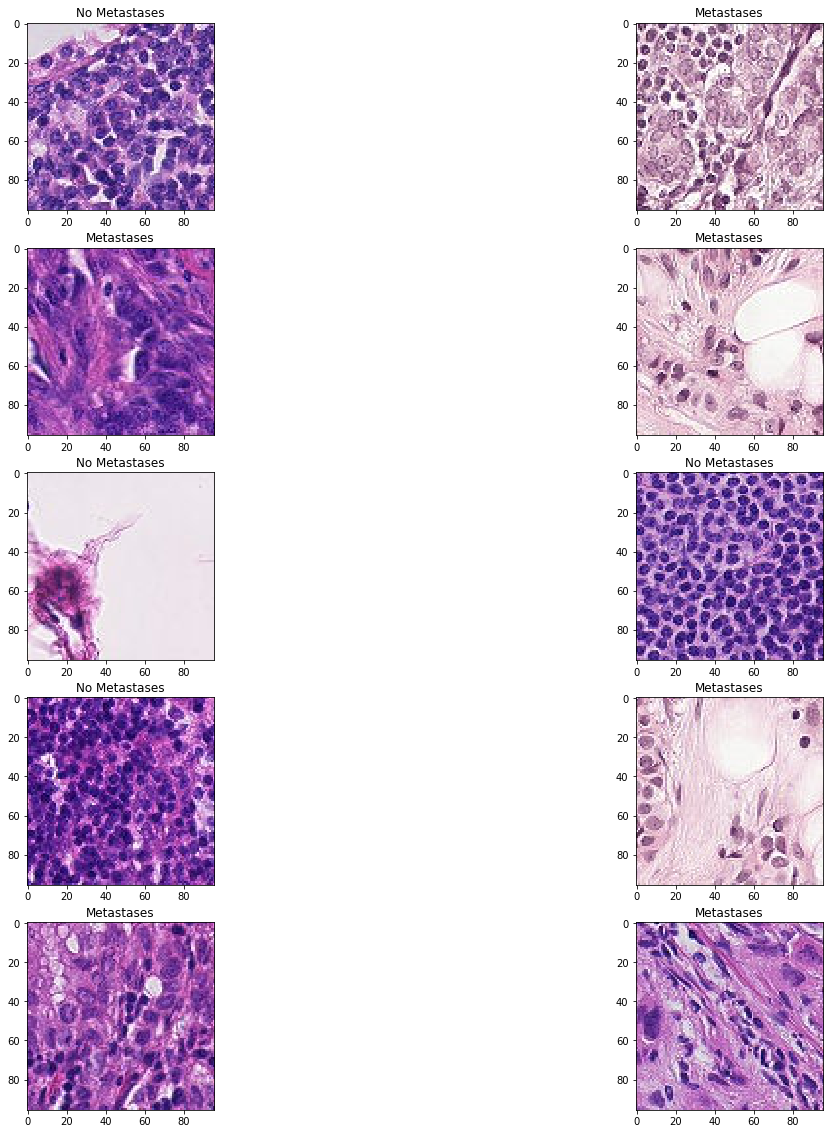

In [13]:
fig, ax = plt.subplots(5,2, figsize=(20,20))
for i, (img, label) in enumerate(zip(sample_img, sample_y)):
    ax[i//2,i%2].title.set_text("Metastases" if label == 1 else "No Metastases")
    ax[i//2,i%2].imshow(img)

### Preprocessing

As before, we need to normalize the color channels before feeding the images to our model.  In contrast to our prior lesson however, we are going to use the color channel statistics from ImageNet.  This is because the pretrained model that we are going to use was trained on ImageNet and expects inputs from that distribution.

In [0]:
from PIL import Image
from tensorflow.keras.applications.resnet50 import preprocess_input
color_mean=[0.485, 0.456, 0.406]
color_std=[0.229, 0.224, 0.225]
# def normalize_colors(img):
#     # pImage = Image.fromarray(img)
#     # pImage.resize((200,200))
#     # img = np.array(pImage)
#     img = (img/255. - color_mean) / color_std

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,

    width_shift_range=4,  # randomly shift images horizontally
    height_shift_range=4,  # randomly shift images vertically 
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True
) 

eval_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

## Build Model

### Transfer Learning

In contrast to yesterday where we trained the entire model from scratch, we are going to re-use the body from a pretrained model.  The model that we are going to use was trained on ImageNet, a set of 14 million labelled images.  Empirically, we hav seen that a sophisticated model trained on such a large dataset to convergence is able to extract very useful features across a number of domains, including medical imaging.

Keras makes a number of pretrained models available through its "applications" API which you can learn more about [here](https://keras.io/applications/).  In Code Lab 2, we are going to use ResNet50v2 which offers a good comprimise between size and accuracy.

In [0]:
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.applications import ResNet50

#### ResNet50

Before we get started building our model, let's inspect the architecture of the base model.  This will take a while as we need to download the ~100MB of pretrained weights for the model.

In [17]:
example_resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(96,96,3), pooling=None)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Let's view the summary of the model using the Keras utility.  Immediately, we can tell that this model is significantly larger than the model we trained yesterday.  Note the repitition of blocks and the pattern of reducing spatial dimensionality while increasing filter count as we go higher in the model.

In [18]:
example_resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

Now let's build our real model.

In [0]:
class PCamResnet(Model):
  def __init__(self):
    super(PCamResnet, self).__init__()

    full_model = ResNet50(weights='imagenet', input_shape=(96,96,3),include_top=False)
    self.feature_map = Model(inputs=full_model.input, outputs=full_model.get_layer('bn4d_branch2c').output)
    self.gap = GlobalAveragePooling2D()
    self.dropout = Dropout(0.4)
    self.probability = Dense(1,activation='sigmoid')
    self.head = Sequential([self.gap, self.dropout, self.probability])

  def call(self, x):
    x = self.feature_map(x)
    return self.head(x)

  def features(self, x):
    x = self.feature_map(x)
    return self.gap(x)

  def freeze_base(self):
    for layer in self.feature_map.layers:
      layer.trainable = False

  
  def unfreeze_base(self,top_n=None):
    layers = self.feature_map.layers
    
    if top_n is not None and top_n < len(layers):
      layers = layers[-top_n:]
    for layer in layers:
      print("Unfreezing %s" % layer.name)
      layer.trainable = True

In [20]:
model = PCamResnet()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


At first we will train only the parameters of our head.

In [0]:
model.freeze_base()

## Training

As usual, we need to set up both our loss function and our optimizer.  We will continue to use  Binary Cross Entropy and Adam respectively.

In [0]:
LEARNING_RATE = 0.001
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipvalue=1.)

In [0]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
metrics=['acc']

Let's also set up some callbacks to help us while we train our model.  Keras supports a large number of useful functions.  I recommend you refence the [documentation](https://keras.io/callbacks/) for more information.

In [0]:
save_best = keras.callbacks.ModelCheckpoint('best_model',save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(patience=3,min_lr=LEARNING_RATE/1000)
# tb_cb = keras.callbacks.TensorBoard(log_dir='./logs/model1')
callbacks = [save_best, early_stopping, reduce_lr]

In [0]:
model.compile(optimizer,
              loss=loss_fn,
              metrics=metrics)

In [0]:
EPOCHS=10
BATCH_SIZE=32
FLOW_DIR = '/flow'
if not os.path.exists(FLOW_DIR):
  os.mkdir(FLOW_DIR)

In [0]:
history = model.fit_generator(train_generator.flow(datasets['train']['x'],
                                 datasets['train']['y'],
                                 batch_size=BATCH_SIZE,
                                 save_to_dir=FLOW_DIR,
                                 save_prefix='train_'),
                              steps_per_epoch=len(datasets['train']['x']) / BATCH_SIZE,
                              epochs=EPOCHS,
                              callbacks=callbacks,
                              validation_data=eval_generator.flow(datasets['valid']['x'],
                                 datasets['valid']['y'],
                                 batch_size=BATCH_SIZE,
                                 save_to_dir=FLOW_DIR,
                                 save_prefix='eval_' ),
                              validation_steps=len(datasets['valid']['x']) / BATCH_SIZE,
                              max_queue_size=4)

Epoch 1/10
 942/3125 [========>.....................] - ETA: 4:13 - loss: 0.6124 - acc: 0.6250

In [30]:
%ls /flow

train__10084_9640.png  train__39626_9237.png  train__70347_1494.png
train__10552_6990.png  train__39967_5636.png  train__70488_9153.png
train__10634_2970.png  train__40075_7159.png  train__7058_4171.png
train__10674_8305.png  train__40446_4479.png  train__70820_833.png
train__10880_3625.png  train__40647_3743.png  train__70830_7367.png
train__1111_2525.png   train__40739_6389.png  train__70839_5109.png
train__11129_8084.png  train__41059_4515.png  train__71027_6812.png
train__11244_2036.png  train__41276_4128.png  train__71129_8705.png
train__11386_9747.png  train__41886_6046.png  train__71168_2114.png
train__11563_6028.png  train__42052_6930.png  train__71628_6356.png
train__11666_351.png   train__42415_5531.png  train__71705_6271.png
train__11713_4210.png  train__42496_3487.png  train__71901_9405.png
train__12318_9647.png  train__42567_7832.png  train__72357_2845.png
train__12351_1244.png  train__42703_1703.png  train__72665_8678.png
train__1251_6214.png   train__42760_416.png   trai

In [27]:
import gc
gc.collect()

104